In [139]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

100%|████████████████████████████████████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


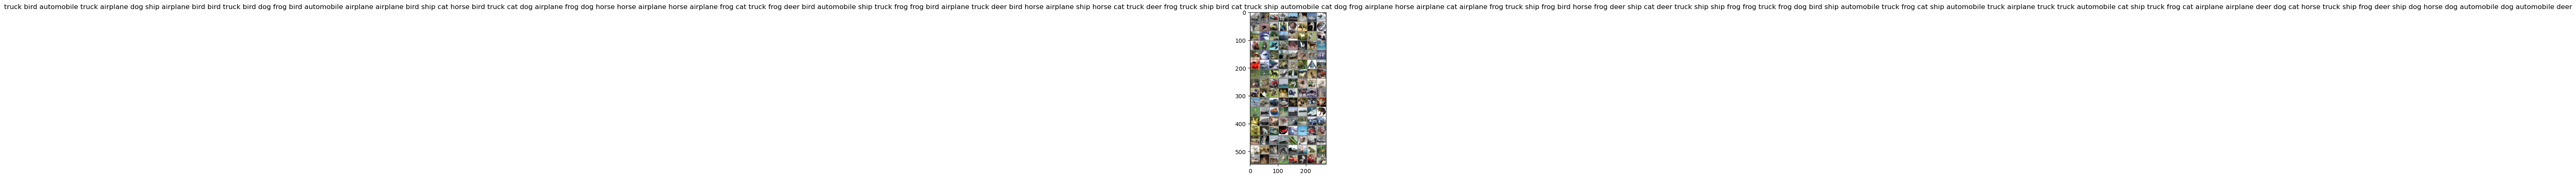

In [140]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 128, shuffle = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle = True)

images, labels = next(iter(trainloader))
plt.imshow(torchvision.utils.make_grid(images).permute(1,2,0) / 2 + 0.5)
plt.title(' '.join(trainset.classes[label] for label in labels));
plt.show()
test_losses = []

In [141]:
class CIFAR10_NN(nn.Module):
    def __init__(self, activation_name):
        super(CIFAR10_NN, self).__init__()
        self.fcLayer1 = nn.Linear(32*32*3, 512)
        self.fcLayer2 = nn.Linear(512, 256)
        self.fcLayer3 = nn.Linear(256, 128)
        self.fcLayer4 = nn.Linear(128, 64)
        self.fcLayer5 = nn.Linear(64, 32)
        self.fcLayer6 = nn.Linear(32, 16)
        self.fcLayer7 = nn.Linear(16, 10)
        if activation_name == "sigmoid": 
            self.activation = nn.Sigmoid()
        elif activation_name == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Tanh()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fcLayer1(x))
        x = self.activation(self.fcLayer2(x))
        x = self.activation(self.fcLayer3(x))
        x = self.activation(self.fcLayer4(x))
        x = self.activation(self.fcLayer5(x))
        x = self.activation(self.fcLayer6(x))
        x = self.fcLayer7(x)
        return x

In [142]:
def train_and_test(activation):
    device = torch.device("cpu")
    model = CIFAR10_NN(activation).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.001)

    epochs = 10
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss=criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            last_loss = loss.item()

            # Only print gradients for the last batch of the epoch
            if batch_idx == len(trainloader) - 1:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {last_loss:.4f}")
                check_gradients(model)
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        test_losses.append(test_loss / len(testloader))
        average_loss = running_loss / len(trainloader)
        train_losses.append(average_loss)
        print(f"{epoch + 1} / {epochs}, activation = {activation}, loss = {average_loss: .4f}")
    return train_losses, test_losses

In [143]:
def check_gradients(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"{name} Gradient Norm: {param.grad.norm().item()}")

In [144]:
activation_fns = ["sigmoid", "tanh", "relu"]
results = {}
for activation in activation_fns:
    results[activation] = (train_and_test(activation))

Epoch 1/10, Loss: 2.3202
fcLayer1.weight Gradient Norm: 2.8331365683698095e-05
fcLayer1.bias Gradient Norm: 6.24699794116168e-07
fcLayer2.weight Gradient Norm: 5.195179983275011e-05
fcLayer2.bias Gradient Norm: 4.505791366682388e-06
fcLayer3.weight Gradient Norm: 0.00026937428629025817
fcLayer3.bias Gradient Norm: 3.325168654555455e-05
fcLayer4.weight Gradient Norm: 0.0013347652275115252
fcLayer4.bias Gradient Norm: 0.00023238470021169633
fcLayer5.weight Gradient Norm: 0.0076364693231880665
fcLayer5.bias Gradient Norm: 0.0019086768152192235
fcLayer6.weight Gradient Norm: 0.033471912145614624
fcLayer6.bias Gradient Norm: 0.011684642173349857
fcLayer7.weight Gradient Norm: 0.17799581587314606
fcLayer7.bias Gradient Norm: 0.08758211135864258
1 / 10, activation = sigmoid, loss =  2.3435
Epoch 2/10, Loss: 2.3478
fcLayer1.weight Gradient Norm: 2.6506917492952198e-05
fcLayer1.bias Gradient Norm: 1.1532591770446743e-06
fcLayer2.weight Gradient Norm: 9.763198613654822e-05
fcLayer2.bias Gradient

[2.3435020654097847, 2.329130723348359, 2.3200573244363145, 2.314215182038524, 2.310371573928677, 2.307788375088626, 2.306053687239547, 2.304908996347881, 2.304152544197219, 2.303636383827385] [2.335427622251873, 2.323997204816794, 2.316639559178413, 2.3120245601557476, 2.3083716736564153, 2.3069107321244253, 2.305421856385243, 2.3042196563527555, 2.3041124223153804, 2.3034024389484262]


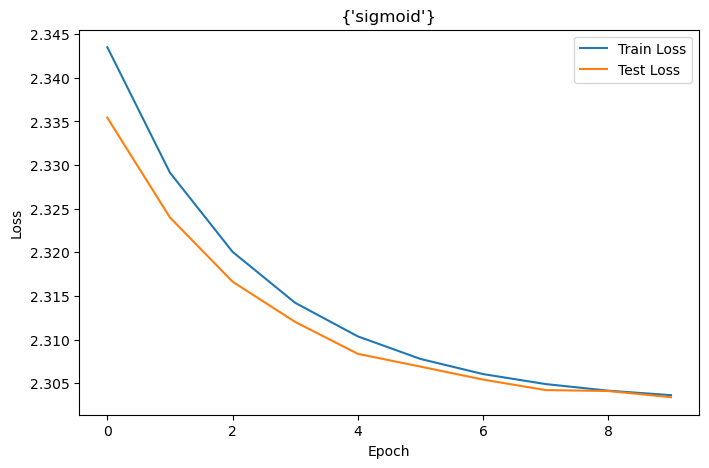

[2.3124160181226023, 2.3078965799278004, 2.3034633285249284, 2.2987632397800457, 2.293603108667047, 2.2877806013502426, 2.280941869901574, 2.2728274868577336, 2.2630336882208315, 2.2514524215932394] [2.3108383673655837, 2.3052503187445144, 2.3012108048306237, 2.2956678595723985, 2.290288858775851, 2.2838714545286156, 2.2766342495061176, 2.26824561855461, 2.256641556945028, 2.2445388655119305]


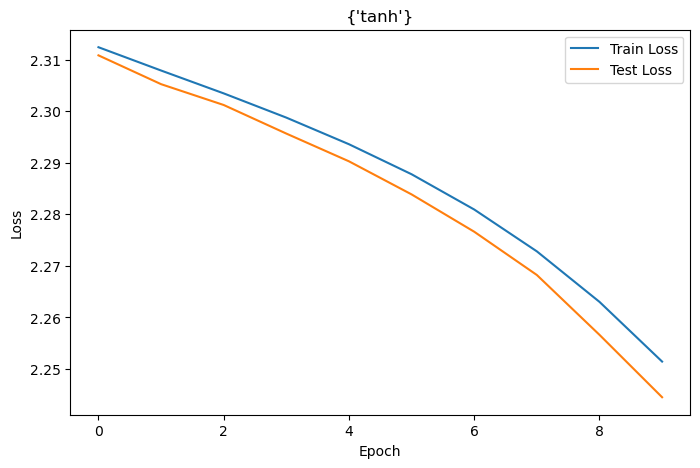

[2.314813207787321, 2.3137180860085254, 2.312774331368449, 2.3118984437049805, 2.311072740408466, 2.31034604606726, 2.309657038325239, 2.309021724154577, 2.308494137985932, 2.3079507918004185] [2.3137855258169053, 2.3132717005814176, 2.312415032447139, 2.3114864282970187, 2.3104611650297913, 2.3104925397076186, 2.308953547779518, 2.308764913414098, 2.3081767559051514, 2.307382927665228]


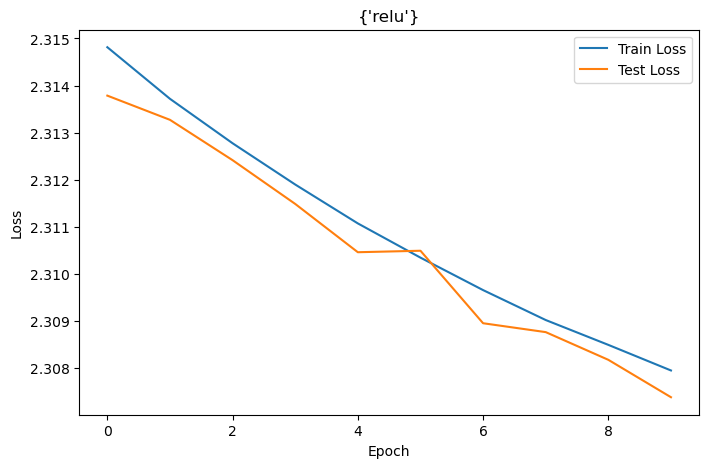

In [145]:
for name, result in results.items():
    print(result[0], result[1])
    plt.figure(figsize=(8, 5))
    plt.plot(result[0], label = 'Train Loss')
    plt.plot(result[1], label = 'Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title({name})
    plt.legend()
    plt.show()